# HW4 Trees, Forests, and Bag of Words

Official instructions:

https://www.cs.tufts.edu/comp/135/2020f/hw4.html

This is the *starter code* notebook.

In [38]:
import numpy as np
import pandas as pd
import os
import sys
import time

In [39]:
import sklearn.tree
import sklearn.linear_model
import sklearn.metrics
import sklearn.ensemble

In [40]:
# From the HW4 starter code
from pretty_print_sklearn_tree import pretty_print_sklearn_tree

In [41]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Load all data from train/valid/test

In [42]:
# TODO fix to path on your local system
DATA_DIR = os.path.join("data_product_reviews")

### Load training

In [43]:
x_tr_df = pd.read_csv(os.path.join(DATA_DIR, 'x_train.csv.zip'))
y_tr_df = pd.read_csv(os.path.join(DATA_DIR, 'y_train.csv'))
x_tr_NF = np.minimum(x_tr_df.values, 1.0).copy()
y_tr_N = y_tr_df.values[:,0].copy()

print("Training data")
print("x_tr_NF.shape: %s" % str(x_tr_NF.shape))
print("y_tr_N.shape : %s" % str(y_tr_N.shape))
print("mean(y_tr_N) : %.3f" % np.mean(y_tr_N))

Training data
x_tr_NF.shape: (6346, 7729)
y_tr_N.shape : (6346,)
mean(y_tr_N) : 0.500


### Load validation set

In [44]:
x_va_df = pd.read_csv(os.path.join(DATA_DIR, 'x_valid.csv.zip'))
y_va_df = pd.read_csv(os.path.join(DATA_DIR, 'y_valid.csv'))

x_va_TF = np.minimum(x_va_df.values, 1.0).copy()
y_va_T = y_va_df.values[:,0].copy()

print("Validation data")
print("x_va_TF.shape: %s" % str(x_va_TF.shape))
print("y_va_T.shape : %s" % str(y_va_T.shape))
print("mean(y_va_T) : %.3f" % np.mean(y_va_T))

Validation data
x_va_TF.shape: (792, 7729)
y_va_T.shape : (792,)
mean(y_va_T) : 0.490


### Load test set 

In [45]:
x_te_df = pd.read_csv(os.path.join(DATA_DIR, 'x_test.csv.zip'))
y_te_df = pd.read_csv(os.path.join(DATA_DIR, 'y_test.csv'))

x_te_TF = np.minimum(x_te_df.values, 1.0).copy()
y_te_T = y_te_df.values[:,0].copy()

print("Heldout Test data")
print("x_te_TF.shape: %s" % str(x_te_TF.shape))
print("y_te_T.shape : %s" % str(y_te_T.shape))
print("mean(y_te_T) : %.3f" % np.mean(y_te_T))

Heldout Test data
x_te_TF.shape: (793, 7729)
y_te_T.shape : (793,)
mean(y_te_T) : 0.515


### Load vocabulary as a list of strings

In [46]:
vocab_list = x_tr_df.columns.tolist()

In [47]:
for word in vocab_list[:8]:
    print(word)
print("...")
for word in vocab_list[-8:]:
    print(word)

good
great
time
book
don't
work
i_have
read
...
never_get
i'd_like
loves_it
an_author
nomin
could_give
bad_but
gap


### Pack training and validation sets into big arrays (so we can use sklearn's hyperparameter search tools)

In [48]:
xall_LF = np.vstack([x_tr_NF, x_va_TF])
yall_L = np.hstack([y_tr_N, y_va_T])

In [49]:
valid_indicators_L = np.hstack([
    -1 * np.ones(y_tr_N.size), # -1 means never include this example in any test split
    0  * np.ones(y_va_T.size), #  0 means include in the first test split (we count starting at 0 in python)
    ])

In [50]:
# Create splitter object using Predefined Split
# Will be used later by all hyperparameter searches

my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)

# Problem 1: Decision Trees

## 1A: Train a simple tree with depth 3

In [51]:
simple_tree = sklearn.tree.DecisionTreeClassifier(
    max_depth=3, min_samples_split=2, min_samples_leaf=1, criterion='gini')

### **Fit the tree** 

**TODO Train on the training set** in the next coding cell

In [52]:
simple_tree.fit(x_tr_df, y_tr_df) #TODO

DecisionTreeClassifier(max_depth=3)

### **Print Tree** 

Use a helper function from the starter code

In [53]:
pretty_print_sklearn_tree(simple_tree, feature_names=vocab_list)

The binary tree structure has 15 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    0 are leaves
- depth   2 has    4 nodes, of which    0 are leaves
- depth   3 has    8 nodes, of which    8 are leaves
The decision tree:  (Note: Y = 'yes' to above question; N = 'no')
Decision: X['great'] <= 0.50?
  Y Decision: X['excel'] <= 0.50?
    Y Decision: X['disappoint'] <= 0.50?
      Y Leaf: p(y=1 | this leaf) = 0.430 (4041 total training examples)
      N Leaf: p(y=1 | this leaf) = 0.114 (368 total training examples)
    N Decision: X['disappoint'] <= 0.50?
      Y Leaf: p(y=1 | this leaf) = 0.903 (277 total training examples)
      N Leaf: p(y=1 | this leaf) = 0.429 (14 total training examples)
  N Decision: X['return'] <= 0.50?
    Y Decision: X['bad'] <= 0.50?
      Y Leaf: p(y=1 | this leaf) = 0.745 (1413 total training examples)
      N Leaf: p(y=1 | this leaf) = 0.415 (142 total training examples)
    N Decision: X['movie'] <= 0.50?
    

## 1B : Find best Decision Tree with grid search

In [54]:
# Construct the default predictor
# Any hyperparameters here may be overridden by the hyperparameter grid

tree = sklearn.tree.DecisionTreeClassifier(
    criterion='gini', min_samples_split=2, min_samples_leaf=1)

In [55]:
tree_hyperparameter_grid_by_name = dict(
    max_depth=[2, 8, 32, 128],
    min_samples_leaf=[1, 3, 9],
    random_state = [101],
    )

**TODO Build the Grid Search** in the next coding cell

Hint: See Lab for Grid Search: https://github.com/tufts-ml-courses/comp135-20f-assignments/blob/master/labs/day13_HyperparameterSearch.ipynb

Key Function: sklearn.model_selection.GridSearchCV

Key Requirements:

* Provide the above tree_hyperparameter_grid_by_name dictionary as the set of hyperparameters to search
* Set scoring='balanced_accuracy', since our target metric is balanced accuracy
* Set cv=my_splitter so you can use the predefined split we defined earlier.
* Set return_train_score=True (we want training set scores as well as test set scores)
* Set refit=False (we only want fits on x_tr not on x_all)

In [56]:
tree_grid_searcher = sklearn.model_selection.GridSearchCV(
    tree,
    tree_hyperparameter_grid_by_name,
    scoring='balanced_accuracy',
    cv=my_splitter,
    return_train_score=True,
    refit=False,
    )

### Do the search!


In [57]:
start_time_sec = time.time()
tree_grid_searcher.fit(xall_LF, yall_L)
elapsed_time_sec = time.time() - start_time_sec

### Build dataframe of results

Move the results of grid search into a nice pandas data frame.

In [58]:
tree_search_results_df = pd.DataFrame(tree_grid_searcher.cv_results_).copy()
print("Grid search of %3d configurations done after %6.1f sec" % (
    tree_search_results_df.shape[0], elapsed_time_sec))

Grid search of  12 configurations done after  115.4 sec


### Display search results

This block will make a pretty printed table of the results of your grid search

In [59]:
pd.set_option('precision', 4)
tree_keys = ['param_max_depth', 'param_min_samples_leaf']
tree_search_results_df.sort_values(tree_keys, inplace=True)
tree_search_results_df[tree_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score', 'mean_fit_time']]

,param_max_depth,param_min_samples_leaf,mean_train_score,mean_test_score,rank_test_score,mean_fit_time
0,2,1,0.6404,0.6339,10,1.6665
1,2,3,0.6404,0.6339,10,1.5985
2,2,9,0.6404,0.6339,10,1.6255
3,8,1,0.7279,0.6989,7,5.0745
4,8,3,0.7232,0.6978,8,5.0886
5,8,9,0.7123,0.6962,9,5.0389
6,32,1,0.9187,0.7325,3,12.8547
7,32,3,0.8752,0.7349,2,12.5908
8,32,9,0.8121,0.7197,6,11.8971
9,128,1,0.9981,0.7366,1,22.2720


In [60]:
print("Printing a dict of the best hyperparameters")
print(tree_grid_searcher.best_params_)

Printing a dict of the best hyperparameters
{'max_depth': 128, 'min_samples_leaf': 1, 'random_state': 101}


### Build the best decision tree

**TODO Build the Best Tree** in the next coding cell

This is necessary so you have the specific best performing tree in your workspace.

Although you fit many trees in the search, they were not stored, so we need to recreate the best one.

Hint: Just feed the best hyperparameters as keyword args to construct the tree. Or see the lab about grid search.

In [61]:

best_tree = tree.set_params(criterion='gini', min_samples_leaf=1, random_state=101, max_depth=128) #TODO
best_tree.fit(x_tr_NF, y_tr_N)

DecisionTreeClassifier(max_depth=128, random_state=101)

### Interpret the best decision tree

In [62]:
best_tree.tree_

In [63]:
pretty_print_sklearn_tree(best_tree, feature_names=vocab_list)

The binary tree structure has 1587 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    0 are leaves
- depth   2 has    4 nodes, of which    0 are leaves
- depth   3 has    8 nodes, of which    0 are leaves
- depth   4 has   16 nodes, of which    5 are leaves
- depth   5 has   22 nodes, of which    6 are leaves
- depth   6 has   32 nodes, of which   13 are leaves
- depth   7 has   38 nodes, of which   21 are leaves
- depth   8 has   34 nodes, of which   16 are leaves
- depth   9 has   36 nodes, of which   13 are leaves
- depth  10 has   46 nodes, of which   23 are leaves
- depth  11 has   46 nodes, of which   26 are leaves
- depth  12 has   40 nodes, of which   17 are leaves
- depth  13 has   46 nodes, of which   25 are leaves
- depth  14 has   42 nodes, of which   24 are leaves
- depth  15 has   36 nodes, of which   18 are leaves
- depth  16 has   36 nodes, of which   16 are leaves
- depth  17 has   40 nodes, of which   22 are leaves
- de

# Problem 2: Random forest

In [64]:
forest = sklearn.ensemble.RandomForestClassifier(
    criterion='gini', min_samples_split=2, random_state=101)

## 2A: Best Random Forest via grid search

Follow the instructions and using what you learn in 1B to finish this step.

This block might take 2-10 minutes. (Takes about 2 min on staff Macbook laptops.)

If yours runs significantly longer, try this out on Google Colab instead.

In [68]:
forest = sklearn.ensemble.RandomForestClassifier(
    n_estimators=125,
    criterion='gini',
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1)


In [69]:
forest_hyperparameter_grid_by_name = dict(
    max_features=[3, 10, 33, 100, 333],
    max_depth=[16, 32],
    min_samples_leaf=[1],
    n_estimators=[125],
    random_state=[101],
    )

In [71]:
# TODO construct a GridSearchCV object like you did above.

forest_searcher = sklearn.model_selection.GridSearchCV(
    forest,
    forest_hyperparameter_grid_by_name,
    scoring='balanced_accuracy',
    cv=my_splitter,
    return_train_score=True,
    refit=False,
    )

### Do the search!

In [72]:
start_time_sec = time.time()
forest_searcher.fit(xall_LF, yall_L)
elapsed_time_sec = time.time() - start_time_sec

### Build dataframe of results

In [73]:
forest_search_results_df = pd.DataFrame(forest_searcher.cv_results_).copy()
print("Grid search of %3d configurations done after %6.1f sec" % (
    forest_search_results_df.shape[0], elapsed_time_sec))

Grid search of  10 configurations done after  131.3 sec


### Display search results

In [74]:
pd.set_option('precision', 4)
forest_keys = ['param_max_depth', 'param_min_samples_leaf']
forest_search_results_df.sort_values(forest_keys, inplace=True)
forest_search_results_df[forest_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score', 'mean_fit_time']]

,param_max_depth,param_min_samples_leaf,mean_train_score,mean_test_score,rank_test_score,mean_fit_time
0,16,1,0.9289,0.7582,10,0.9489
1,16,1,0.9340,0.8550,1,1.6745
2,16,1,0.9277,0.8400,5,4.0529
3,16,1,0.9217,0.8340,6,10.5925
4,16,1,0.8715,0.7942,9,31.2394
5,32,1,0.9800,0.8192,7,1.4293
6,32,1,0.9751,0.8534,2,2.7991
7,32,1,0.9720,0.8448,3,7.1569
8,32,1,0.9713,0.8405,4,17.4726
9,32,1,0.9527,0.8185,8,49.3927


### Build the best random forest using the best hyperparameters found in 2B and train it.

This is necessary so you have the specific best performing forest in your workspace.


In [75]:
print("Printing a dict of the best hyperparameters")
print(forest_searcher.best_params_)

Printing a dict of the best hyperparameters
{'max_depth': 16, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 125, 'random_state': 101}


In [85]:

best_forest = forest.set_params(criterion='gini', min_samples_leaf=1, random_state=101, max_depth=16, n_estimators=125, max_features=10) #TODO
best_forest.fit(x_tr_NF, y_tr_N)


RandomForestClassifier(max_depth=16, max_features=10, n_estimators=125,
                       random_state=101)

Feature ranking:
1. feature waste_of (0.010943)
2. feature poor (0.008432)
3. feature great (0.007901)
4. feature your_money (0.007810)
5. feature return (0.007591)
6. feature bad (0.006844)
7. feature excel (0.005947)
8. feature not_recommend (0.005205)
9. feature love (0.004644)
10. feature disappoint (0.004526)
11. feature horribl (0.004516)
12. feature wonder (0.003989)
13. feature refund (0.003568)
14. feature awful (0.003533)
15. feature worst (0.003409)
16. feature work (0.003380)
17. feature easy (0.003374)
18. feature money (0.003359)
19. feature an_excellent (0.003289)
20. feature the_worst (0.003174)
21. feature not_work (0.003124)
22. feature not_worth (0.002907)
23. feature don't_waste (0.002886)
24. feature high (0.002857)
25. feature terribl (0.002833)
26. feature works (0.002814)
27. feature don't_buy (0.002810)
28. feature price (0.002722)
29. feature the_best (0.002631)
30. feature i_returned (0.002585)
31. feature love_this (0.002574)
32. feature beauti (0.002514)
33

2969. feature escap (0.000080)
2970. feature few_times (0.000080)
2971. feature was_excited (0.000080)
2972. feature video (0.000079)
2973. feature say_it (0.000079)
2974. feature why_i (0.000079)
2975. feature proof (0.000079)
2976. feature are_very (0.000079)
2977. feature avoid_this (0.000079)
2978. feature out_as (0.000079)
2979. feature dealt (0.000079)
2980. feature here_the (0.000079)
2981. feature contribut (0.000079)
2982. feature speech (0.000079)
2983. feature applic (0.000079)
2984. feature the_latter (0.000079)
2985. feature one_could (0.000079)
2986. feature thought_this (0.000079)
2987. feature but_now (0.000079)
2988. feature alright (0.000079)
2989. feature a_high (0.000079)
2990. feature told_me (0.000079)
2991. feature a_family (0.000079)
2992. feature hotel (0.000079)
2993. feature think (0.000078)
2994. feature at (0.000078)
2995. feature the_work (0.000078)
2996. feature pull (0.000078)
2997. feature only_one (0.000078)
2998. feature and_who (0.000078)
2999. featu

5968. feature you_use (0.000001)
5969. feature this_pan (0.000001)
5970. feature heavili (0.000001)
5971. feature revolut (0.000001)
5972. feature so_hard (0.000001)
5973. feature settl (0.000001)
5974. feature have_more (0.000001)
5975. feature the_hard (0.000001)
5976. feature fly (0.000001)
5977. feature maybe_the (0.000001)
5978. feature except (0.000001)
5979. feature minutes_i (0.000001)
5980. feature scene_where (0.000001)
5981. feature reads (0.000001)
5982. feature especially_in (0.000001)
5983. feature resolut (0.000001)
5984. feature the_cd (0.000001)
5985. feature will_need (0.000001)
5986. feature not_fit (0.000001)
5987. feature screw (0.000001)
5988. feature catch (0.000001)
5989. feature play_a (0.000001)
5990. feature the_director (0.000001)
5991. feature be_prepared (0.000001)
5992. feature end_i (0.000001)
5993. feature there (0.000001)
5994. feature as_some (0.000001)
5995. feature edges (0.000001)
5996. feature of_film (0.000001)
5997. feature stars_for (0.000001)


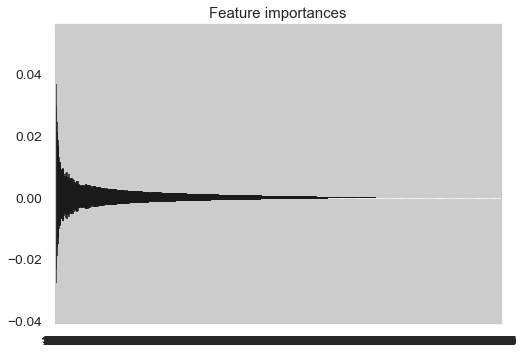

In [86]:

importances = best_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_tr_NF.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, vocab_list[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_tr_NF.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x_tr_NF.shape[1]), indices)
plt.xlim([-1, x_tr_NF.shape[1]])
plt.show()

## 2B & Figure 2 : Feature Importances 

Access the **feature_importances_** attribute of your trained forest to get a score for each term in our vocabulary.

A higher value of this score indicates the feature is "more important".

In one panel of Figure 2, display a list of the top 10 vocabulary words of your best forest with highest feature importance.

In another panel of Figure 2, display a list of 10 randomly chosen terms that have close-to-zero feature importance (use anything with importance less than 0.00001).

### Figure 2.2
**Sample Output** (Feel free to print all words and organize them in any software)

|**Important Words**|**Unimportant Words**|
|:-:|:-:|
|waste_of |  a_review  |
|poor |  description_of  |
|great |  character_in  |
|your_money |  firmware  |
|return |  go_wrong  |
|bad |  need_a  |
|excel |  try_it  |
|not_recommend |  came_to  |
|love |  of_coffee  |
|disappoint |  the_high  |

# Problem 3: Comparison of models

### 3A Implementation **TODO**:

Selecting the best logistic regression with L1 penalty

Table 3 in Report

In [ ]:
lasso = sklearn.linear_model.LogisticRegression(
    penalty='l1', solver='saga', random_state=101)

In [ ]:
lasso_hyperparameter_grid_by_name = dict(
    C=np.logspace(-4, 4, 9),
    max_iter=[20, 40], # sneaky way to do "early stopping" 
                       # we'll take either iter 20 or iter 40 in training process, by best valid performance
    )

#### TODO Selecting the best logistic regression with L1 penalty
Hint: Follow 1B and 2A

### Table 3: Comparison of methods on the bag-of-words to sentiment classification task.

Please report balanced accuracy on the train, valid, and test sets, to 3 digits of precision

**Sample Output** (Feel free to print all values and organize them in any software)

|**method**|**train**|**valid**|**test**|
|:-|:-:|:-:|:-:|
|L1-penalized LogisticRegression	|0.123	|0.456	|0.890|
|best RandomForest	|0.123	|0.456	|0.890|
|best Tree	|0.123	|0.456	|0.890|
|simple Tree	|0.123	|0.456	|0.890|